In [1]:
import os
os.chdir(os.getcwd() + '/../../')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.bert_utils import *

# specify GPU
device = torch.device("cuda")

In [3]:
comments = pd.read_csv('data/comments/preprocessed_comments.csv', index_col=0)
comments = comments.dropna()
comments.head()

,toxic,comment_text
0,0,explanation why the edits make under my userna...
1,0,d'aww ! he match this background colour i be s...
2,0,"hey man , i be really not try to edit war . it..."
3,0,`` more i can not make any real suggestion on ...
4,0,"you , sir , be my hero . any chance you rememb..."


In [4]:
temp_text, test_text, temp_labels, test_labels = train_test_split(comments['comment_text'], 
                                                                  comments['toxic'], 
                                                                  random_state=0, 
                                                                  test_size=0.2, 
                                                                  stratify=comments['toxic'])


train_text, val_text, train_labels, val_labels = train_test_split(temp_text, 
                                                                  temp_labels, 
                                                                  random_state=0, 
                                                                  test_size=0.2, 
                                                                  stratify=temp_labels)

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(0.0, 1000.0)

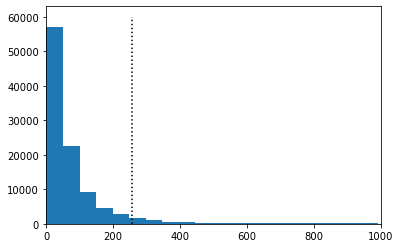

In [6]:
seq_len = [len(i.split()) for i in train_text]
plt.hist(seq_len, bins=100)
plt.vlines(256, 0, 60000, linestyles='dotted', color='k')
plt.xlim(0, 1000)

In [7]:
n_tokens = 128

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

In [8]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [9]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)
  
        return x


In [10]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [11]:
#load weights of best model
path = 'models/bert_v1.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
import math

# get predictions for test data in batch

batch_size = 100
n_batch = math.ceil(len(val_seq)/batch_size)

preds = []
for b in range(n_batch):
    
    if (b+1)%20 == 0 or b==0:
        print(f"predicting batch {b+1} of {n_batch}")
    
    with torch.no_grad():
        pred = model(val_seq[b*batch_size:(b+1)*batch_size].to(device), 
                     val_mask[b*batch_size:(b+1)*batch_size].to(device))
        pred = pred.detach().cpu()
        preds.append(pred)
    
preds = torch.cat(preds)
preds = preds.numpy()

predicting batch 1 of 256
predicting batch 20 of 256
predicting batch 40 of 256
predicting batch 60 of 256
predicting batch 80 of 256
predicting batch 100 of 256
predicting batch 120 of 256
predicting batch 140 of 256
predicting batch 160 of 256
predicting batch 180 of 256
predicting batch 200 of 256
predicting batch 220 of 256
predicting batch 240 of 256


In [13]:
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     23085
           1       0.44      0.81      0.57      2447

    accuracy                           0.88     25532
   macro avg       0.71      0.85      0.75     25532
weighted avg       0.93      0.88      0.90     25532



In [14]:
get_evaluation_df(val_y, preds, 'BERT v1')

,accuracy,precision,recall,f1,roc_auc
BERT v1,0.883675,0.441407,0.805067,0.570188,0.848538
